In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-31a0kwro
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-31a0kwro
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=c3ae1c2f10f34c255f0b267e890f91c5908db09bb7624490f08039171c2ed7ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-glgkz5mp/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.4 MB/s eta 0:00:00


### Download SAM weights

In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data


!cp /content/drive/MyDrive/agri_data/agri_0_9831.jpeg /content/data/
!cp /content/drive/MyDrive/agri_data/agri_0_9881.jpeg /content/data/
!cp /content/drive/MyDrive/agri_data/agri_0_9888.jpeg /content/data/
!cp /content/drive/MyDrive/agri_data/agri_0_9618.jpeg /content/data/


!cp /content/drive/MyDrive/JSON_Annotation_Files/annotation_0_9831.json /content/data/
!cp /content/drive/MyDrive/JSON_Annotation_Files/annotation_0_9881.json /content/data/
!cp /content/drive/MyDrive/JSON_Annotation_Files/annotation_0_9888.json /content/data/
!cp /content/drive/MyDrive/JSON_Annotation_Files/annotation_0_9618.json /content/data/





#!cp /content/drive/MyDrive/agri_data/agri_0_7963.jpeg /content/data/
#!cp /content/drive/MyDrive/agri_data/agri_0_9971.jpeg /content/data/
#!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
#!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

/content
mkdir: cannot create directory ‘/content/data’: File exists
/content/data


## Load Model

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation



In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
import os

IMAGE_NAME = "agri_0_9618.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Generate masks with SAM

In [ ]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

## Generate Segmentation with Bounding Box



In [ ]:
mask_predictor = SamPredictor(sam)

### Draw Box



In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpeg;base64,"+encoded

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

loading Roboflow workspace...
loading Roboflow project...


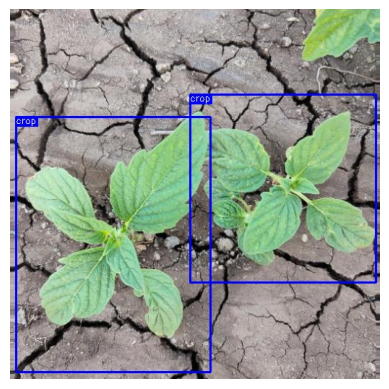

Bounding Box: (377.5, 248.0), (634.5, 508.0)
Confidence: 0.9246095418930054
Class Label: crop
Bounding Box: (142.5, 325.5), (411.5, 678.5)
Confidence: 0.9200474619865417
Class Label: crop


In [ ]:
from roboflow import Roboflow
import json
import matplotlib.pyplot as plt
from PIL import Image

rf = Roboflow(api_key="U6Ip9jNY094LOqogiOwb")
project = rf.workspace("myworkspace-01zku").project("cropweedd")
model = project.version(1).model

# Predict on a local image
prediction = model.predict(IMAGE_PATH, confidence=40, overlap=30)

# Save the predicted image
prediction.save("prediction.jpg")
# Load the predicted image
predicted_image = Image.open("prediction.jpg")

# Plot the image
plt.imshow(predicted_image)
plt.axis('off')
plt.show()

# Infer on a local image and save the JSON response
#image_path = "/content/data/agri_0_417.jpeg"
json_response = model.predict(IMAGE_PATH, confidence=40, overlap=30).json()
with open("prediction.json", "w") as f:
    json.dump(json_response, f)

# Extract bounding box coordinates from the saved JSON file
with open("prediction.json", "r") as f:
    data = json.load(f)

predictions = data['predictions']
for prediction in predictions:
    x_min = prediction['x']
    y_min = prediction['y']
    width = prediction['width']
    height = prediction['height']
    x_max = x_min + width
    y_max = y_min + height
    confidence = prediction['confidence']
    class_label = prediction['class']

    print(f"Bounding Box: ({x_min}, {y_min}), ({x_max}, {y_max})")
    print(f"Confidence: {confidence}")
    print(f"Class Label: {class_label}")


### Generate masks with SAM

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
#default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0]
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
#cv2.imwrite('sm.jpg', sm)

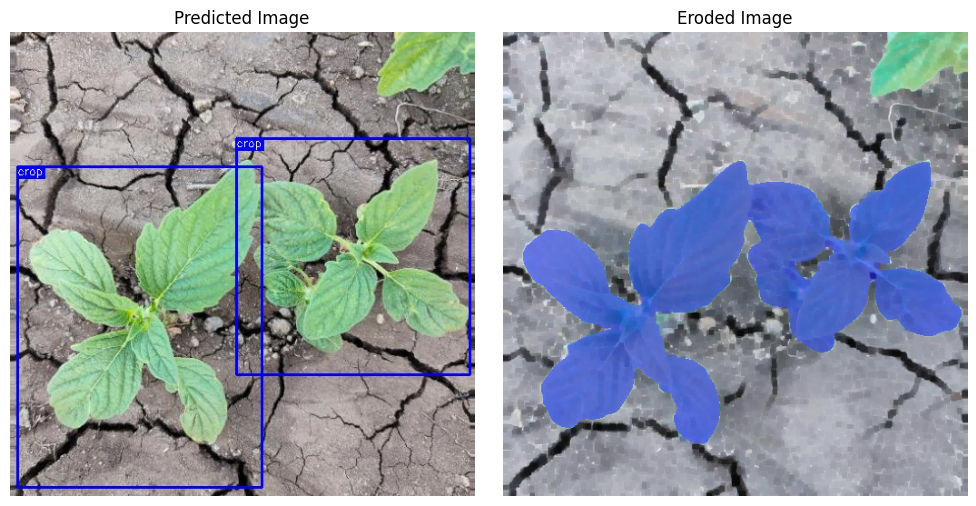

In [ ]:
import supervision as sv
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

kernel = np.ones((5, 5), np.uint8)
dilated_image = cv2.dilate(sm, kernel, iterations=1)
eroded_image = cv2.erode(dilated_image, kernel, iterations=1)

# Apply thresholding to generate binary masks
_, eroded_mask = cv2.threshold(eroded_image, 100, 255, cv2.THRESH_BINARY)

cv2.imwrite('eroded_image.jpg', eroded_image)
cv2.imwrite('eroded_mask.jpg', eroded_mask)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(predicted_image)
axes[0].set_title('Predicted Image')

axes[1].imshow(eroded_image)
axes[1].set_title('Eroded Image')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

###Generating ground truth mask from annotated json file

In [ ]:
import cv2
import numpy as np
import json
from google.colab.patches import cv2_imshow

def generate_ground_truth_mask(annotation_file, image_shape):
    with open(annotation_file, 'r') as file:
        annotation_data = json.load(file)

    # Create a blank mask image
    mask = np.zeros(image_shape, dtype=np.uint8)

    for box in annotation_data['boxes']:
        if box['type'] == 'polygon':
            points = np.array(box['points'], dtype=np.int32)
            cv2.fillPoly(mask, [points], 255)

    mask = cv2.bitwise_not(mask)

    return mask

# Specify the annotation file and image shape
annotation_file = 'annotation_0_9881.json'
image_shape = (512, 512)

# Generate the ground truth mask
ground_truth_mask = generate_ground_truth_mask(annotation_file, image_shape)

# Display the ground truth mask
#cv2_imshow(ground_truth_mask)
cv2.imwrite("gt_mask.jpeg", ground_truth_mask)

True

###**Performance Metrics**


In [ ]:
import numpy as np

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return round(iou, 5)

def calculate_precision_recall_f1(mask_gt, mask_pred):
    tp = np.sum(np.logical_and(mask_gt, mask_pred))
    fp = np.sum(np.logical_and(np.logical_not(mask_gt), mask_pred))
    fn = np.sum(np.logical_and(mask_gt, np.logical_not(mask_pred)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    precision = round(precision, 5)
    recall = round(recall, 5)
    f1_score = round(f1, 5)

    return precision, recall, f1_score

def calculate_dice_coefficient(segmented_image, ground_truth_image):
    # Flatten the images to 1D arrays
    segmented_flat = segmented_image.flatten()
    ground_truth_flat = ground_truth_image.flatten()

    # Calculate True Positive, False Positive, and False Negative counts
    tp = np.sum(np.logical_and(segmented_flat == 255, ground_truth_flat == 255))
    fp = np.sum(np.logical_and(segmented_flat == 255, ground_truth_flat == 0))
    fn = np.sum(np.logical_and(segmented_flat == 0, ground_truth_flat == 255))

    # Calculate Dice coefficient
    dice_coefficient = (2 * tp) / (2 * tp + fp + fn)
    dice_coefficient = round(dice_coefficient, 5)

    return dice_coefficient

def calculate_pixel_accuracy(mask_gt, mask_pred):
    correct_pixels = np.sum(mask_gt == mask_pred)
    total_pixels = mask_gt.size
    pixel_accuracy = correct_pixels / total_pixels
    pixel_accuracy = round(pixel_accuracy, 5)

    return pixel_accuracy

# Example usage
mask_gt = cv2.imread("gt_mask.jpeg", cv2.IMREAD_GRAYSCALE)
mask_pred = cv2.imread("eroded_mask.jpg", cv2.IMREAD_GRAYSCALE)

precision, recall, f1_score = calculate_precision_recall_f1(mask_gt, mask_pred)
print("F1 Score:", f1_score)

iou = calculate_iou(mask_gt, mask_pred)
print("IoU:", iou)

dice_coefficient = calculate_dice_coefficient(mask_pred, mask_gt)
print("Dice Coefficient:", dice_coefficient)

pixel_accuracy = calculate_pixel_accuracy(mask_gt, mask_pred)
print("Pixel Accuracy:", pixel_accuracy)

F1 Score: 0.93737
IoU: 0.88212
Dice Coefficient: 0.98308
Pixel Accuracy: 0.78889


**Writing to a file**

In [ ]:
# Define the file names for each metric
precision_file = '/content/drive/MyDrive/Metrics Folder/Erosion/precision.txt'
recall_file = '/content/drive/MyDrive/Metrics Folder/Erosion/recall.txt'
f1_score_file = '/content/drive/MyDrive/Metrics Folder/Erosion/f1_score.txt'
iou_file = '/content/drive/MyDrive/Metrics Folder/Erosion/iou.txt'
dice_coefficient_file = '/content/drive/MyDrive/Metrics Folder/Erosion/dice_coefficient.txt'
pixel_accuracy_file = '/content/drive/MyDrive/Metrics Folder/Erosion/pixel_accuracy.txt'



---



In [ ]:

# Write precision to file
with open(precision_file, 'a') as file:
    file.write(str(precision) + '\n')

# Write recall to file
with open(recall_file, 'a') as file:
    file.write(str(recall) + '\n')

# Write F1 score to file
with open(f1_score_file, 'a') as file:
    file.write(str(f1_score) + '\n')

# Write IoU to file
with open(iou_file, 'a') as file:
    file.write(str(iou) + '\n')

# Write Dice coefficient to file
with open(dice_coefficient_file, 'a') as file:
    file.write(str(dice_coefficient) + '\n')

# Write pixel accuracy to file
with open(pixel_accuracy_file, 'a') as file:
    file.write(str(pixel_accuracy) + '\n')




---



####**Mean or Average**

In [ ]:
# Read precision values from file
with open(precision_file, 'r') as file:
    precision_values = [float(line.strip()) for line in file.readlines()]

# Read recall values from file
with open(recall_file, 'r') as file:
    recall_values = [float(line.strip()) for line in file.readlines()]

# Read F1 score values from file
with open(f1_score_file, 'r') as file:
    f1_score_values = [float(line.strip()) for line in file.readlines()]

# Read IoU values from file
with open(iou_file, 'r') as file:
    iou_values = [float(line.strip()) for line in file.readlines()]

# Read Dice coefficient values from file
with open(dice_coefficient_file, 'r') as file:
    dice_coefficient_values = [float(line.strip()) for line in file.readlines()]

# Read pixel accuracy values from file
with open(pixel_accuracy_file, 'r') as file:
    pixel_accuracy_values = [float(line.strip()) for line in file.readlines()]

# Calculate the mean of each metric
precision_mean = sum(precision_values) / len(precision_values)
recall_mean = sum(recall_values) / len(recall_values)
f1_score_mean = sum(f1_score_values) / len(f1_score_values)
iou_mean = sum(iou_values) / len(iou_values)
dice_coefficient_mean = sum(dice_coefficient_values) / len(dice_coefficient_values)
pixel_accuracy_mean = sum(pixel_accuracy_values) / len(pixel_accuracy_values)

# Display the mean values
print("F1 Score Mean:", round(f1_score_mean,6))
print("IoU Mean:", round(iou_mean,6))
print("Dice Coefficient Mean:", round(dice_coefficient_mean,6))
print("Pixel Accuracy Mean:", round(pixel_accuracy_mean,6))


F1 Score Mean: 0.820905
IoU Mean: 0.70416
Dice Coefficient Mean: 0.923888
Pixel Accuracy Mean: 0.543921


####**Plot the values of the Methods**

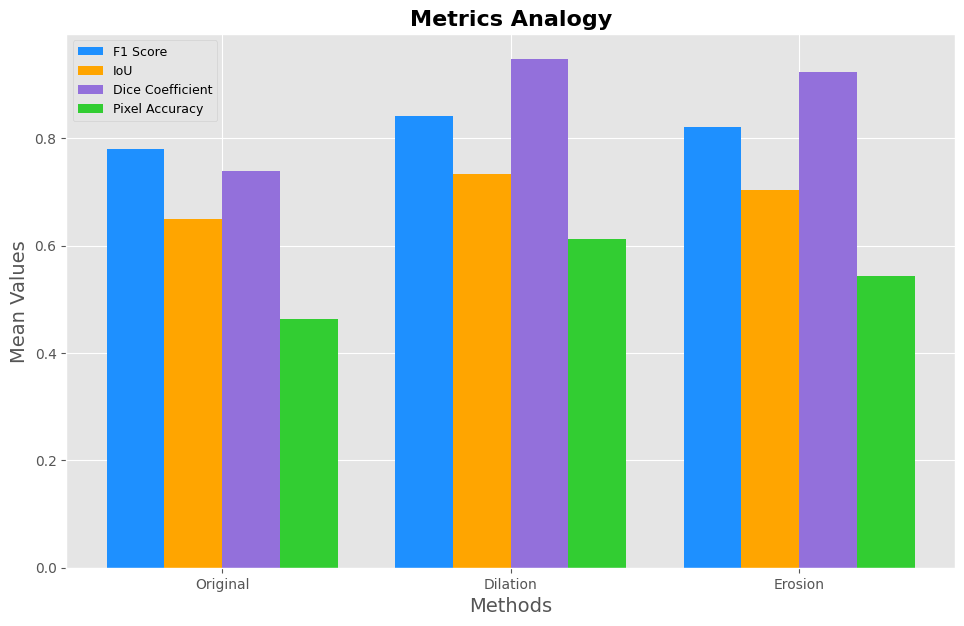

In [ ]:
import matplotlib.pyplot as plt

# Data
methods = ['Original', 'Dilation', 'Erosion']
f1_score_mean = [0.780999, 0.841704, 0.820905]
iou_mean = [0.648862, 0.733252, 0.70416]
dice_coeff_mean = [0.739053, 0.946992, 0.923888]
pixel_accuracy_mean = [0.463257, 0.61172, 0.543921]

# Set the style for the plot
plt.style.use('ggplot')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for each method
bar_width = 0.2
index = list(range(len(methods)))  # Convert range to list

ax.bar(index, f1_score_mean, width=bar_width, label='F1 Score', color='dodgerblue')
ax.bar([i + bar_width for i in index], iou_mean, width=bar_width, label='IoU', color='orange')
ax.bar([i + 2*bar_width for i in index], dice_coeff_mean, width=bar_width, label='Dice Coefficient', color='mediumpurple')
ax.bar([i + 3*bar_width for i in index], pixel_accuracy_mean, width=bar_width, label='Pixel Accuracy', color='limegreen')

# Set the labels, title, and ticks
ax.set_xlabel('Methods', fontsize=14)
ax.set_ylabel('Mean Values', fontsize=14)
ax.set_title('Metrics Analogy', fontsize=16, fontweight='bold')
ax.set_xticks([i + 1.5*bar_width for i in index])  # Center the ticks below the bars
ax.set_xticklabels(methods, fontsize=10)  # Reduced font size for tick labels
ax.legend(fontsize=9)

# Move the plot below the index
ax.set_position([0.1, 0.3, 0.8, 0.6])

# Display the plot
plt.tight_layout()
plt.show()


####**Plots with repect to particular file**

**F1 Score**

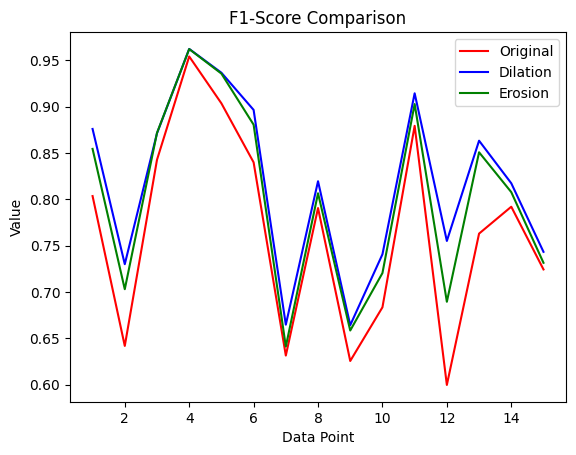

In [ ]:
import matplotlib.pyplot as plt

def load_data(file_path):
    with open(file_path, 'r') as file:
        # Assuming the file contains one numeric value per line
        data = [float(line.strip()) for line in file]
    return data

# File paths for the three data files
original_file = '/content/drive/MyDrive/Metrics Folder/Original/f1_score.txt'
dilation_file = '/content/drive/MyDrive/Metrics Folder/Dilation/f1_score.txt'
erosion_file = '/content/drive/MyDrive/Metrics Folder/Erosion/f1_score.txt'

# Load data from the three files
original_values = load_data(original_file)
dilation_values = load_data(dilation_file)
erosion_values = load_data(erosion_file)

# Specify the desired range of data points
start_data_point = 1
end_data_point = 15

# Generate x-axis values for the specified range
x = range(start_data_point, end_data_point + 1)

# Create the line plot for the specified range
plt.plot(x, original_values[start_data_point-1:end_data_point], label='Original', color='red')
plt.plot(x, dilation_values[start_data_point-1:end_data_point], label='Dilation', color='blue')
plt.plot(x, erosion_values[start_data_point-1:end_data_point], label='Erosion', color='green')

# Add labels and title
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('F1-Score Comparison')
plt.legend()

# Show the plot
plt.show()

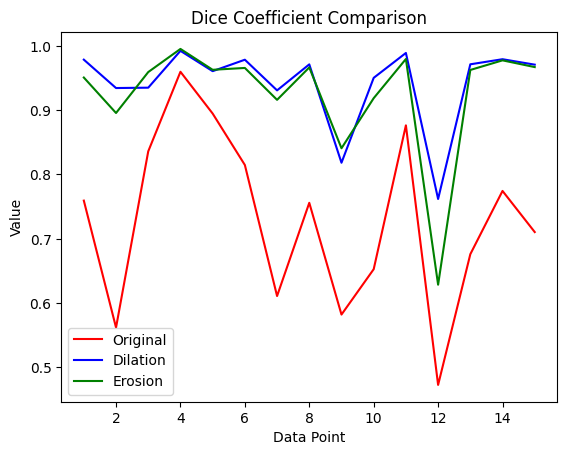

In [ ]:
import matplotlib.pyplot as plt

def load_data(file_path):
    with open(file_path, 'r') as file:
        # Assuming the file contains one numeric value per line
        data = [float(line.strip()) for line in file]
    return data

# File paths for the three data files
original_file = '/content/drive/MyDrive/Metrics Folder/Original/dice_coefficient.txt'
dilation_file = '/content/drive/MyDrive/Metrics Folder/Dilation/dice_coefficient.txt'
erosion_file = '/content/drive/MyDrive/Metrics Folder/Erosion/dice_coefficient.txt'

# Load data from the three files
original_values = load_data(original_file)
dilation_values = load_data(dilation_file)
erosion_values = load_data(erosion_file)

# Specify the desired range of data points
start_data_point = 1
end_data_point = 15

# Generate x-axis values for the specified range
x = range(start_data_point, end_data_point + 1)

# Create the line plot for the specified range
plt.plot(x, original_values[start_data_point-1:end_data_point], label='Original', color='red')
plt.plot(x, dilation_values[start_data_point-1:end_data_point], label='Dilation', color='blue')
plt.plot(x, erosion_values[start_data_point-1:end_data_point], label='Erosion', color='green')

# Add labels and title
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Dice Coefficient Comparison')
plt.legend()

# Show the plot
plt.show()

**IoU**

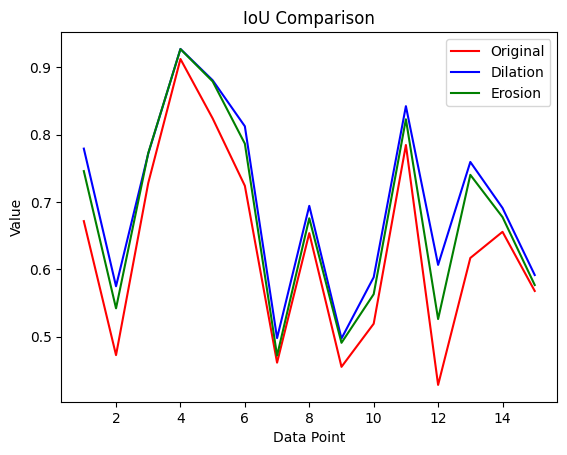

In [ ]:
import matplotlib.pyplot as plt

def load_data(file_path):
    with open(file_path, 'r') as file:
        # Assuming the file contains one numeric value per line
        data = [float(line.strip()) for line in file]
    return data

# File paths for the three data files
original_file = '/content/drive/MyDrive/Metrics Folder/Original/iou.txt'
dilation_file = '/content/drive/MyDrive/Metrics Folder/Dilation/iou.txt'
erosion_file = '/content/drive/MyDrive/Metrics Folder/Erosion/iou.txt'

# Load data from the three files
original_values = load_data(original_file)
dilation_values = load_data(dilation_file)
erosion_values = load_data(erosion_file)

# Specify the desired range of data points
start_data_point = 1
end_data_point = 15

# Generate x-axis values for the specified range
x = range(start_data_point, end_data_point + 1)

# Create the line plot for the specified range
plt.plot(x, original_values[start_data_point-1:end_data_point], label='Original', color='red')
plt.plot(x, dilation_values[start_data_point-1:end_data_point], label='Dilation', color='blue')
plt.plot(x, erosion_values[start_data_point-1:end_data_point], label='Erosion', color='green')

# Add labels and title
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('IoU Comparison')
plt.legend()

# Show the plot
plt.show()

**Pixel Accuracy**

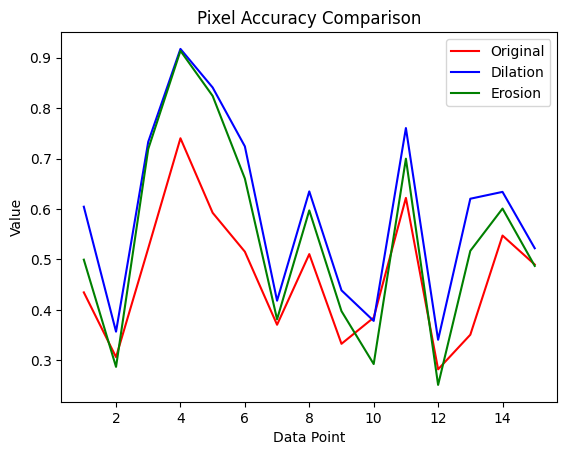

In [ ]:
import matplotlib.pyplot as plt

def load_data(file_path):
    with open(file_path, 'r') as file:
        # Assuming the file contains one numeric value per line
        data = [float(line.strip()) for line in file]
    return data

# File paths for the three data files
original_file = '/content/drive/MyDrive/Metrics Folder/Original/pixel_accuracy.txt'
dilation_file = '/content/drive/MyDrive/Metrics Folder/Dilation/pixel_accuracy.txt'
erosion_file = '/content/drive/MyDrive/Metrics Folder/Erosion/pixel_accuracy.txt'

# Load data from the three files
original_values = load_data(original_file)
dilation_values = load_data(dilation_file)
erosion_values = load_data(erosion_file)

# Specify the desired range of data points
start_data_point = 1
end_data_point = 15

# Generate x-axis values for the specified range
x = range(start_data_point, end_data_point + 1)

# Create the line plot for the specified range
plt.plot(x, original_values[start_data_point-1:end_data_point], label='Original', color='red')
plt.plot(x, dilation_values[start_data_point-1:end_data_point], label='Dilation', color='blue')
plt.plot(x, erosion_values[start_data_point-1:end_data_point], label='Erosion', color='green')

# Add labels and title
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Pixel Accuracy Comparison')
plt.legend()

# Show the plot
plt.show()

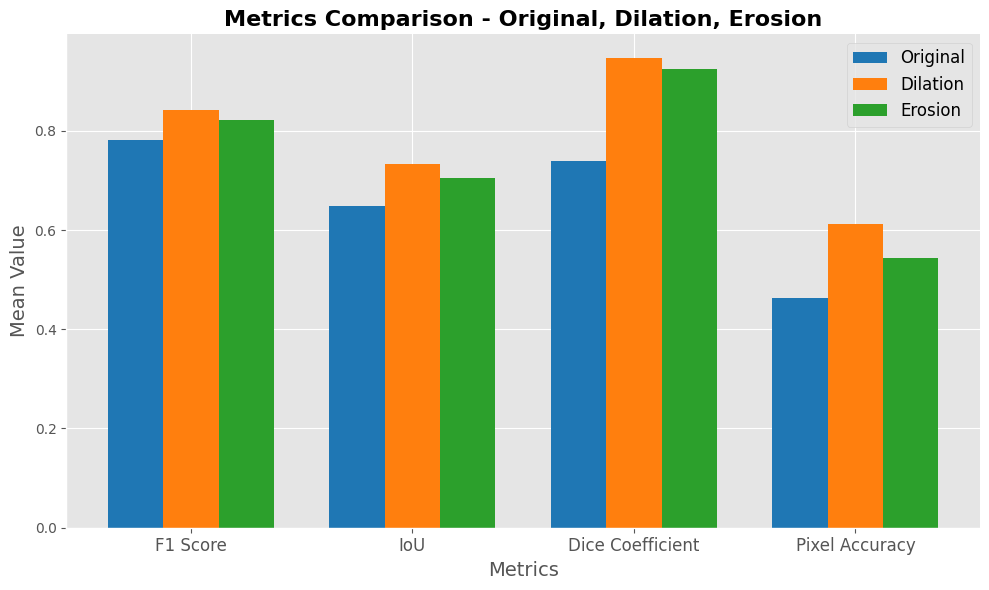

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
categories = ['F1 Score', 'IoU', 'Dice Coefficient', 'Pixel Accuracy']
original_means = [0.780999, 0.648862, 0.739053, 0.463257]
dilation_means = [0.841704, 0.733252, 0.946992, 0.61172]
erosion_means = [0.820905, 0.70416, 0.923888, 0.543921]

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Custom colors for the bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Bar plots for each category
rects1 = ax.bar(x - width, original_means, width, label='Original', color=colors[0])
rects2 = ax.bar(x, dilation_means, width, label='Dilation', color=colors[1])
rects3 = ax.bar(x + width, erosion_means, width, label='Erosion', color=colors[2])

# Set the labels, title, and legend
ax.set_xlabel('Metrics', fontsize=14)
ax.set_ylabel('Mean Value', fontsize=14)
ax.set_title('Metrics Comparison - Original, Dilation, Erosion', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(fontsize=12)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
